In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
iris = load_iris()

from sklearn.preprocessing import StandardScaler

In [2]:
y = iris.target[50:]
y.shape
X = iris.data[50:]
X.shape
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [3]:
class Radam():

    def __init__(self, num_iter=5000, lr=0.05, bias=False, verbose=True,lamda=0.001):
        # ハイパーパラメータを属性として記録
        self.lam = lamda
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    #シグモイド関数
    def _rogistic_hypothesis(self,X): 
        return np.dot(X,self.coef_.T) 
    def sigmoid2(self,z):
        
        return 1/(1 + np.exp(-z))
    #損失計算
    def loss_logi2(self,h,y):
        loss = np.sum((-y*np.log(h))-((1-y)*np.log(1-h)))/len(y) + (self.lam * np.sum(self.coef_**2)/len(y))
        return loss
    # 最急降下法
    def _gradient_descent2(self,X,error):


        #θ0あり
        if self.bias ==True:
            gradient1 = np.dot(error.T,X[:,0:1])/len(X)
            gradient2 = np.dot(error.T,X[:,1:])/len(X)+(self.lam*self.coef_[:,1:]/X.shape[0])
            #print(self.coef_)
            self.coef_[:,0:1] -= self.lr * gradient1
            #print(self.coef_)
            self.coef_[:,1:] -= self.lr * gradient2
            #print(self.coef_)
        #θ0なし
        else:
            gradient = np.dot(error.T,X)/len(X)+(self.lam*self.coef_/X.shape[0])
            self.coef_ -= self.lr * gradient
            
        return self.coef_

               
    def fit(self, X, y, X_val=None, y_val=None):

        #Xにバイアスを追加
        if self.bias ==True:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
                
        #yを一列に変換
        y = y[:,np.newaxis]
        y = y-1
        if y_val is not None:
            y_val = y_val[:,np.newaxis]
            y_val = y_val -1
        #重みをランダムで生成
        np.random.seed(seed=71)
        self.coef_ = np.random.rand(1,X.shape[1]) 
        #print(self.coef_.shape)
        for ite in range(self.iter):
            #sigmoid
            z = self._rogistic_hypothesis(X)
            y_hat = self.sigmoid2(z)
            #損失計算
            lost = self.loss_logi2(y_hat, y)

            #print(lost)
            #格納
            self.loss[ite] += lost

            #error
            error = y_hat - y
            #print(y_hat.shape)
            #theta の更新
            self.coef_ = self._gradient_descent2(X,error)
            
            #検証None判定用
            if y_val is not None:
                #推定
                z_val = self._rogistic_hypothesis(X_val)
                y_hat_val = self.sigmoid2(z_val)
                #損失
                lost_val = self.loss_logi2(y_hat_val, y_val)
                #格納
                self.val_loss[ite] += lost_val

        
        
        if self.verbose == True:
            #verboseをTrueにした際は学習過程を出力
            print("loss値{}".format(self.loss))


    def predict(self, X):

        threshold = 0.5
        pred = np.where((self.predict_proba(X))>= threshold,2,1)

        return pred

    def predict_proba(self, X):

        if self.bias ==True:
            X = np.insert(X, 0, 1, axis=1)

        #y_predict = np.dot(X,self.coef_ .T) 
        z = self._rogistic_hypothesis(X)

        return self.sigmoid2(z)

In [4]:
sr = ScratchLogisticRegression(bias=True)
sr.fit(X_train,y_train,X_test,y_test)

loss値[0.410581   0.40830098 0.40605082 ... 0.05734834 0.05734485 0.05734135]


In [6]:
def graff(loss,val_loss):
    plt.plot(range(len(loss)),loss,label="train_loss")
    plt.plot(range(len(val_loss)),val_loss,label="test_loss")
    plt.legend()
#    plt.ylim(0,30)
    plt.show()

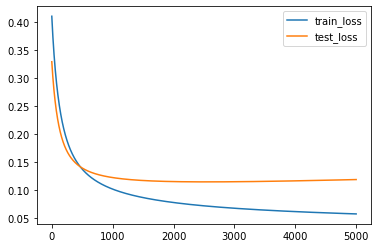

In [7]:
graff(sr.loss,sr.val_loss)

In [8]:
#Adam (出典：http://arxiv.org/abs/1412.6980v8)
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [13]:
# Adamの実装
class Adam2():

    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

In [42]:
# coding: utf-8
import numpy as np
import math
#from itertools import izip
from sklearn.metrics import accuracy_score, recall_score


class Adam3():
    def __init__(self,loss_type='log', alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.weight = np.zeros(feat_dim)  # features weight
        self.loss_type = loss_type  # type of loss function
        self.feat_dim = feat_dim  # number of dimension
        self.x = np.zeros(feat_dim)  # feature
        self.m = np.zeros(feat_dim)  # 1st moment vector
        self.v = np.zeros(feat_dim)  # 2nd moment vector
        self.alpha = alpha  # step size
        self.beta1 = beta1  # Exponential decay rates for moment estimates
        self.beta2 = beta2  # Exponential decay rates for moment estimates
        self.epsilon = epsilon
        self.t = 1  # timestep

    def fit(self, data_fname, label_fname):
        with open(data_fname, 'r') as f_data, open(label_fname, 'r') as f_label:
            for data, label in izip(f_data, f_label):
                self.features = np.array(data.rstrip().split(','), dtype=np.float64)
                y = int(-1) if int(label.rstrip())<=0 else int(1)  # posi=1, nega=-1に統一
                # update weight
                self.update(self.predict(self.features), y)
                self.t += 1
        return self.weight

    def predict(self, features): #margin
        return np.dot(self.weight, features)

    def calc_loss(self,m): # m=py=wxy
        if self.loss_type == 'hinge':
            return max(0,1-m)
        elif self.loss_type == 'log':
            # if m<=-700: m=-700
            return math.log(1+math.exp(-m))

    # gradient of loss function
    def calc_dloss(self,m): # m=py=wxy
        if self.loss_type == 'hinge':
            res = -1.0 if (1-m)>0 else 0.0 # lossが0を超えていなければloss=0.そうでなければ-mの微分で-1になる
            return res
        elif self.loss_type == 'log':
            if m < 0.0:
                return float(-1.0) / (math.exp(m) + 1.0) # yx-e^(-m)/(1+e^(-m))*yx
            else:
                ez = float( math.exp(-m) )
                return -ez / (ez + 1.0) # -yx+1/(1+e^(-m))*yx

    def update(self, pred, y):
        grad = y*self.calc_dloss(y*pred)*self.features  # gradient
        self.m = self.beta1*self.m + (1 - self.beta1)*grad  # update biased first moment estimate
        self.v = self.beta2*self.v + (1 - self.beta2)*grad**2  # update biased second raw moment estimate
        mhat = self.m/(1-self.beta1**self.t)  # compute bias-corrected first moment estimate
        vhat = self.v/(1-self.beta2**self.t)  # compute bias-corrected second raw moment estimate
        self.alpha *= np.sqrt(1-self.beta2**self.t)/(1-self.beta1**self.t)  # update stepsize
        self.weight -= self.alpha * mhat/(np.sqrt(vhat) + self.epsilon)  # update weight



In [64]:
class Linear():
    def __init__(self,num_iter=1000, feat_dim=2, loss_type='log', alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8),lamda=0.3,lr=0.01,bias=True,verbose=True):
        # ハイパーパラメータを属性として記録
        self.lam = lamda
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose

        self.weight = np.zeros(feat_dim)  # features weight
        self.loss_type = loss_type  # type of loss function
        self.feat_dim = feat_dim  # number of dimension
        self.x = np.zeros(feat_dim)  # feature
        self.m = np.zeros(feat_dim)  # 1st moment vector
        self.v = np.zeros(feat_dim)  # 2nd moment vector
        self.alpha = alpha  # step size
        self.beta1 = beta1  # Exponential decay rates for moment estimates
        self.beta2 = beta2  # Exponential decay rates for moment estimates
        self.epsilon = epsilon
        self.t = 1  # timestep

        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        #シグモイド関数
    def _rogistic_hypothesis(self,X): 
        return np.dot(X,self.coef_.T) 
    def sigmoid2(self,z):
        
        return 1/(1 + np.exp(-z))
    #損失計算
    def loss_logi2(self,h,y):
        loss = np.sum((-y*np.log(h))-((1-y)*np.log(1-h)))/len(y) + (self.lam * np.sum(self.coef_**2)/len(y))
        return loss

    def update(self, pred, y):
        grad = y*self.calc_dloss(y*pred)*self.features  # gradient
        self.m = self.beta1*self.m + (1 - self.beta1)*grad  # update biased first moment estimate
        self.v = self.beta2*self.v + (1 - self.beta2)*grad**2  # update biased second raw moment estimate
        mhat = self.m/(1-self.beta1**self.t)  # compute bias-corrected first moment estimate
        vhat = self.v/(1-self.beta2**self.t)  # compute bias-corrected second raw moment estimate
        self.alpha *= np.sqrt(1-self.beta2**self.t)/(1-self.beta1**self.t)  # update stepsize
        self.weight -= self.alpha * mhat/(np.sqrt(vhat) + self.epsilon)  # update weight
        
    def calc_dloss(self,m): # m=py=wxy
        if self.loss_type == 'hinge':
            res = -1.0 if (1-m)>0 else 0.0 # lossが0を超えていなければloss=0.そうでなければ-mの微分で-1になる
            return res
        elif self.loss_type == 'log':
            if m < 0.0:
                return float(-1.0) / (math.exp(m) + 1.0) # yx-e^(-m)/(1+e^(-m))*yx
            else:
                ez = float( math.exp(-m) )
                return -ez / (ez + 1.0) # -yx+1/(1+e^(-m))*yx

    def _gradient_descent2(self,X,error):


        #θ0あり
        if self.bias ==True:
            gradient1 = np.dot(error.T,X[:,0:1])/len(X)
            gradient2 = np.dot(error.T,X[:,1:])/len(X)+(self.lam*self.coef_[:,1:]/X.shape[0])
            #print(self.coef_)
            self.coef_[:,0:1] -= self.lr * gradient1
            #print(self.coef_)
            self.coef_[:,1:] -= self.lr * gradient2
            #print(self.coef_)
        #θ0なし
        else:
            gradient = np.dot(error.T,X)/len(X)+(self.lam*self.coef_/X.shape[0])
            self.coef_ -= self.lr * gradient
            
        return self.coef_

               
    def fit(self, X, y, X_val=None, y_val=None):

        #Xにバイアスを追加
        if self.bias ==True:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
                
        #yを一列に変換
        y = y[:,np.newaxis]
        y = y-1
        if y_val is not None:
            y_val = y_val[:,np.newaxis]
            y_val = y_val -1
        #重みをランダムで生成
        np.random.seed(seed=71)
        self.coef_ = np.random.rand(1,X.shape[1]) 
        #print(self.coef_.shape)
        for ite in range(self.iter):
            #sigmoid
            z = self._rogistic_hypothesis(X)
            y_hat = self.sigmoid2(z)
            #損失計算
            lost = self.loss_logi2(y_hat, y)

            #print(lost)
            #格納
            self.loss[ite] += lost

            #error
            error = y_hat - y
            #print(y_hat.shape)
            #theta の更新
            self.coef_ = self._gradient_descent2(X,error)
            
            #検証None判定用
            if y_val is not None:
                #推定
                z_val = self._rogistic_hypothesis(X_val)
                y_hat_val = self.sigmoid2(z_val)
                #損失
                lost_val = self.loss_logi2(y_hat_val, y_val)
                #格納
                self.val_loss[ite] += lost_val

        
        
        if self.verbose == True:
            #verboseをTrueにした際は学習過程を出力
            print("loss値{}".format(self.loss))


    def predict(self, X):

        threshold = 0.5
        pred = np.where((self.predict_proba(X))>= threshold,2,1)

        return pred

    def predict_proba(self, X):

        if self.bias ==True:
            X = np.insert(X, 0, 1, axis=1)

        #y_predict = np.dot(X,self.coef_ .T) 
        z = self._rogistic_hypothesis(X)

        return self.sigmoid2(z)

In [66]:
ad = Linear()
ad.fit(X_train,y_train)

loss値[0.41757962 0.41712739 0.41667638 0.41622659 0.41577801 0.41533063
 0.41488445 0.41443946 0.41399567 0.41355305 0.41311161 0.41267135
 0.41223225 0.41179431 0.41135754 0.41092191 0.41048743 0.41005409
 0.40962189 0.40919082 0.40876088 0.40833206 0.40790436 0.40747777
 0.40705229 0.40662791 0.40620463 0.40578245 0.40536135 0.40494134
 0.40452241 0.40410455 0.40368777 0.40327205 0.40285739 0.40244379
 0.40203125 0.40161975 0.4012093  0.40079988 0.40039151 0.39998416
 0.39957784 0.39917255 0.39876827 0.39836501 0.39796276 0.39756152
 0.39716128 0.39676203 0.39636379 0.39596653 0.39557026 0.39517497
 0.39478066 0.39438732 0.39399496 0.39360356 0.39321313 0.39282365
 0.39243513 0.39204757 0.39166095 0.39127527 0.39089054 0.39050674
 0.39012388 0.38974194 0.38936093 0.38898085 0.38860168 0.38822343
 0.38784609 0.38746966 0.38709414 0.38671951 0.38634579 0.38597295
 0.38560102 0.38522996 0.3848598  0.38449051 0.3841221  0.38375457
 0.38338791 0.38302212 0.38265719 0.38229312 0.38192991 0

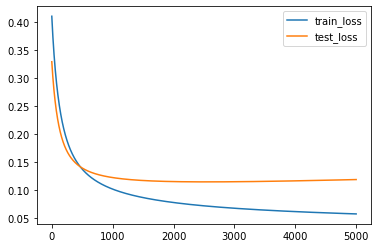

In [67]:
graff(sr.loss,sr.val_loss)

In [65]:
if __name__=='__main__':
    data_fname = 'train800.csv'
    label_fname = 'trainLabels800.csv'
    test_data_fname = 'test200.csv'
    test_label_fname = 'testLabels200.csv'

    adam = Adam(40, loss_type='hinge')
    adam.fit(data_fname, label_fname)
    y_true = []
    y_pred = []
    with open(test_data_fname, 'r') as f_data, open(test_label_fname, 'r') as f_label:
        for data, label in izip(f_data, f_label):
            pred_label = adam.predict(np.array(data.rstrip().split(','), dtype=np.float64))
            y_true.append(int(label))
            y_pred.append( 1 if pred_label>0 else 0)
    print 'accuracy:', accuracy_score(y_true, y_pred)
    print 'recall:', recall_score(y_true, y_pred)

SyntaxError: invalid syntax (<ipython-input-65-b25382ab984e>, line 16)

In [ ]:
import numpy as np
from itertools import izip
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score


def get_data(data_fname, label_fname):
    result_data = []
    result_labels = []
    with open(data_fname, 'r') as f_data, open(label_fname, 'r') as f_label:
        for data, label in izip(f_data, f_label):
            result_data.append(data.rstrip().split(','))
            result_labels.append(int(label.rstrip()))
    return np.array(result_data, dtype=np.float64), result_labels

if __name__=='__main__':
     data_fname = 'train800.csv'
    label_fname = 'trainLabels800.csv'
    test_data_fname = 'test200.csv'
    test_label_fname = 'testLabels200.csv'

    data, labels = get_data(data_fname, label_fname)
    test_data, test_labels = get_data(test_data_fname, test_label_fname)

    lr = LogisticRegression()
    model = lr.fit(data, labels)
    y_pred = model.predict(test_data)
    print 'accuracy:', model.score(test_data, test_labels)
    print 'recall:', recall_score(test_labels, y_pred)
